# LIBRARY

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

from sklearn.linear_model import LinearRegression
from statsmodels.formula.api import ols
from statsmodels.formula.api import glm
from statsmodels.genmod.families.family import Binomial
from sklearn.ensemble import RandomForestClassifier

In [2]:
import xgboost as xgb
from sklearn.model_selection import GridSearchCV
from xgboost import XGBClassifier
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
import sklearn.metrics as metrics
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, precision_score, recall_score, roc_auc_score, f1_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import roc_curve
from sklearn.metrics import auc

In [14]:
import scipy as sp

In [4]:
# imbalanced data 해결

from imblearn.under_sampling import *
from imblearn.over_sampling import *
from imblearn.combine import *

In [5]:
from matplotlib import font_manager, rc
[font for font in font_manager.fontManager.ttflist if 'Malgun Gothic' in font.name]
import seaborn as sns
sns.set(style="whitegrid", rc={'font.family':font_manager.FontProperties(fname="c:/Windows/Fonts/malgun.ttf").get_name(), 'figure.figsize': (15, 10)}, font_scale=2)

In [6]:
import warnings
warnings.filterwarnings('ignore')

# DATA

In [109]:
train = pd.read_csv('../Data/train_PCA_jmk_lnd_fl.csv')
valid = pd.read_csv('../Data/valid_PCA_jmk_lnd_fl.csv')
test = pd.read_csv('../Data/test_PCA_jmk_lnd_fl.csv')

In [110]:
train.sample()

,address,address1,address2,ahsm_dstnc,bldng_ar,bldng_cnt,bldng_cnt_in_50m,cctv_dstnc,cctv_in_100m,day,...,lnd_us_sttn_nm_체,lnd_us_sttn_nm_과,lnd_us_sttn_nm_묘,lnd_us_sttn_nm_공,lnd_us_sttn_nm_원,lnd_us_sttn_nm_사,lnd_us_sttn_nm_제,lnd_us_sttn_nm_수,ttl_dwn_flr,ttl_grnd_flr
36695,하동군 금성면,하동군,금성면,1640,107.72,2,0,2567,0,20,...,False,False,False,False,False,False,False,False,0.0,2.0


## f1 score 평가 함수

In [12]:
def evaluation(y, pred):
    confusion = confusion_matrix(y, pred)
    accuracy = accuracy_score(y, pred)
    precision = precision_score(y, pred)
    recall = recall_score(y, pred)
    f1 = f1_score(y, pred)
    roc_score = roc_auc_score(y, pred)
    
    print('정확도(accuracy): {0: .4f}, 정밀도(precision): {1: .4f}, 재현율(recall): {2: 4f}, f1 score: {3: .4f}, auc값: {4: .4f}'.format(accuracy, precision, recall, f1, roc_score))

## Outlier 제거

In [230]:
# 창원시 전체 화재발생 0이라 제외
train = train[train['address1'] != '창원시']

# MAKING DATASET

In [111]:
train.columns

Index(['address', 'address1', 'address2', 'ahsm_dstnc', 'bldng_ar',
       'bldng_cnt', 'bldng_cnt_in_50m', 'cctv_dstnc', 'cctv_in_100m', 'day',
       'dayofweek', 'fire_yes', 'fr_mn_cnt', 'fr_sttn_dstnc',
       'fr_wthr_fclt_dstnc', 'fr_wthr_fclt_in_100m', 'hm_cnt', 'hmdt', 'hour',
       'id', 'jmk', 'lnd_ar', 'minute', 'mlt_us_yn(encode)', 'month',
       'no_tbc_zn_dstnc', 'second', 'sft_emrgnc_bll_dstnc', 'tag',
       'tbc_rtl_str_dstnc', 'tmprtr', 'ttl_ar', 'wnd_drctn', 'wnd_spd', 'year',
       'year-month', 'year-month-day', 'cluster', 'Comp1', 'Comp2', 'jmk_주',
       'jmk_잡', 'jmk_종', 'jmk_차', 'jmk_답', 'jmk_장', 'jmk_양', 'jmk_전', 'jmk_창',
       'jmk_학', 'jmk_목', 'jmk_도', 'jmk_임', 'jmk_철', 'jmk_유', 'jmk_천', 'jmk_구',
       'jmk_체', 'jmk_과', 'jmk_묘', 'jmk_공', 'jmk_원', 'jmk_사', 'jmk_제', 'jmk_수',
       'lnd_us_sttn_nm(clean)', 'lnd_us_sttn_nm_주', 'lnd_us_sttn_nm_잡',
       'lnd_us_sttn_nm_종', 'lnd_us_sttn_nm_차', 'lnd_us_sttn_nm_답',
       'lnd_us_sttn_nm_장', 'lnd_us_sttn_nm_양

In [285]:
train['dayofweek(int)'] = pd.to_datetime(train['year-month-day']).dt.dayofweek
test['dayofweek(int)'] = pd.to_datetime(test['year-month-day']).dt.dayofweek
valid['dayofweek(int)'] = pd.to_datetime(valid['year-month-day']).dt.dayofweek

In [286]:
# choose independent variables(Xs) which are useful!
# 트레이닝에 사용할 변수 목록을 적어주세요.

float_col = ['year', 'month', 'dayofweek(int)', 'hour'
             , 'lnd_ar', 'ttl_ar', 'bldng_ar'
             , 'tmprtr', 'wnd_spd', 'hmdt', 'wnd_drctn'
             , 'Comp1', 'Comp2'
            , 'hm_cnt'
             
#              , 'no_tbc_zn_dstnc', 'bldng_cnt_in_50m', 'fr_wthr_fclt_in_100m', 'cctv_in_100m'
             , 'fr_sttn_dstnc', 'fr_mn_cnt', 'fr_wthr_fclt_dstnc'
             , 'cctv_dstnc', 'tbc_rtl_str_dstnc', 'sft_emrgnc_bll_dstnc', 'ahsm_dstnc']

bool_col =['lnd_us_sttn_nm_주', 'lnd_us_sttn_nm_잡', 'lnd_us_sttn_nm_종', 'lnd_us_sttn_nm_차', 'lnd_us_sttn_nm_답', 'lnd_us_sttn_nm_장', 'lnd_us_sttn_nm_양', 'lnd_us_sttn_nm_전', 'lnd_us_sttn_nm_창', 'lnd_us_sttn_nm_학', 'lnd_us_sttn_nm_목', 'lnd_us_sttn_nm_도', 'lnd_us_sttn_nm_임', 'lnd_us_sttn_nm_철', 'lnd_us_sttn_nm_유', 'lnd_us_sttn_nm_천', 'lnd_us_sttn_nm_구', 'lnd_us_sttn_nm_체', 'lnd_us_sttn_nm_과', 'lnd_us_sttn_nm_묘', 'lnd_us_sttn_nm_공', 'lnd_us_sttn_nm_원', 'lnd_us_sttn_nm_사', 'lnd_us_sttn_nm_제', 'lnd_us_sttn_nm_수'
          , 'jmk_주', 'jmk_잡', 'jmk_종', 'jmk_차', 'jmk_답', 'jmk_장', 'jmk_양', 'jmk_전', 'jmk_창', 'jmk_학', 'jmk_목', 'jmk_도', 'jmk_임', 'jmk_철', 'jmk_유', 'jmk_천', 'jmk_구', 'jmk_체', 'jmk_과', 'jmk_묘', 'jmk_공', 'jmk_원', 'jmk_사', 'jmk_제', 'jmk_수'
           , 'ttl_dwn_flr', 'ttl_grnd_flr'
          ]

independents = float_col + bool_col


# 문자열 제외 'dayofweek', 'year-month','year-month-day', 'address', 'address1', 'address2', 'jmk'
# 관련 없는 열 제외 'id', 'second'(second가 0인게 많아서 fire_yes와 상관관계 높음) 
# 'fr_wthr_fclt_in_100m','ahsm_dstnc' 지역간 편차가 큰 애들 제외
# 독립변수
dependent = ['fire_yes'] # 종속변수

In [287]:
# 적어준 변수 목록을 사용해 데이터를 트레이닝에 맞는 포맷으로 변경합니다.
train_X = train[independents]
train_y = train[dependent]

test_X = test[independents]
valid_X = valid[independents]

In [288]:
# logistic

model_lr = LogisticRegression().fit(train_X, train_y)
pred_lr = model_lr.predict(valid_X)

print(classification_report(valid['fire_yes'], pred_lr))

evaluation(valid['fire_yes'], pred_lr)

              precision    recall  f1-score   support

         0.0       0.84      0.99      0.91      5626
         1.0       0.79      0.14      0.24      1272

    accuracy                           0.83      6898
   macro avg       0.81      0.57      0.57      6898
weighted avg       0.83      0.83      0.78      6898

정확도(accuracy):  0.8344, 정밀도(precision):  0.7851, 재현율(recall):  0.140723, f1 score:  0.2387, auc값:  0.5660


# Undersampling

### Random Under Sampling

In [266]:
sample_X, sample_y = RandomUnderSampler(random_state=17).fit_sample(train_X, train_y)

print(sample_X.shape)

(15306, 72)


In [267]:
data = pd.DataFrame(sample_X, columns=independents)

for x in float_col:
    data[x] = data[x].apply(lambda x: float(x))
    
for x in bool_col:
    data[x] = data[x].apply(lambda x: True if x == 'True' else False)

data.dtypes

year                    float64
month                   float64
hour                    float64
lnd_ar                  float64
ttl_ar                  float64
bldng_ar                float64
tmprtr                  float64
wnd_spd                 float64
hmdt                    float64
wnd_drctn               float64
Comp1                   float64
Comp2                   float64
hm_cnt                  float64
fr_sttn_dstnc           float64
fr_mn_cnt               float64
fr_wthr_fclt_dstnc      float64
cctv_dstnc              float64
tbc_rtl_str_dstnc       float64
sft_emrgnc_bll_dstnc    float64
ahsm_dstnc              float64
lnd_us_sttn_nm_주           bool
lnd_us_sttn_nm_잡           bool
lnd_us_sttn_nm_종           bool
lnd_us_sttn_nm_차           bool
lnd_us_sttn_nm_답           bool
lnd_us_sttn_nm_장           bool
lnd_us_sttn_nm_양           bool
lnd_us_sttn_nm_전           bool
lnd_us_sttn_nm_창           bool
lnd_us_sttn_nm_학           bool
                         ...   
lnd_us_s

In [268]:
# XGB 모델 예측, 검증
model_xgb = XGBClassifier(verbose = True).fit(data, pd.DataFrame(sample_y)[0])

pred_xgb = model_xgb.predict(valid_X)

print(classification_report(valid['fire_yes'], pred_xgb))

evaluation(valid['fire_yes'], pred_xgb)

              precision    recall  f1-score   support

         0.0       0.94      0.30      0.45      5626
         1.0       0.23      0.92      0.36      1272

    accuracy                           0.41      6898
   macro avg       0.58      0.61      0.41      6898
weighted avg       0.81      0.41      0.43      6898

정확도(accuracy):  0.4104, 정밀도(precision):  0.2275, 재현율(recall):  0.917453, f1 score:  0.3646, auc값:  0.6066


In [271]:
# logistic

model_lr = LogisticRegression().fit(sample_X, sample_y)
pred_lr = model_lr.predict(valid_X)
print(classification_report(valid['fire_yes'], pred_lr))

evaluation(valid['fire_yes'], pred_lr)

              precision    recall  f1-score   support

         0.0       0.84      0.99      0.91      5626
         1.0       0.72      0.16      0.26      1272

    accuracy                           0.83      6898
   macro avg       0.78      0.57      0.58      6898
weighted avg       0.82      0.83      0.79      6898

정확도(accuracy):  0.8334, 정밀도(precision):  0.7158, 재현율(recall):  0.160377, f1 score:  0.2620, auc값:  0.5730


### Tomek’s link method

In [297]:
sample_X, sample_y = TomekLinks(random_state=17).fit_sample(train_X, train_y)

print(sample_X.shape)

# max_depth=10, n_estimator=50  learning_rate=0.05

(47997, 73)
              precision    recall  f1-score   support

         0.0       0.87      0.88      0.88      5626
         1.0       0.45      0.43      0.44      1272

    accuracy                           0.80      6898
   macro avg       0.66      0.66      0.66      6898
weighted avg       0.80      0.80      0.80      6898

정확도(accuracy):  0.7995, 정밀도(precision):  0.4544, 재현율(recall):  0.434748, f1 score:  0.4444, auc값:  0.6584


In [323]:
# XGB 모델 예측, 검증
# 최적값 max_depth = 5, n_estimator=50 0.4451
# 최적값 max_depth = 5, n_estimator=100 0.4510
# 최적값 max_depth = 5, n_estimator=130 0.4506
# 최적값 max_depth = 5, n_estimator=148 0.4524
# 최적값 max_depth = 5, n_estimator=149 0.4532 <
# 최적값 max_depth = 5, n_estimator=150 0.4524
# 최적값 max_depth = 5, n_estimator=155 0.4517
# 최적값 max_depth = 5, n_estimator=170 0.4502
# 최적값 max_depth = 5, n_estimator=200 0.4471


# 최적값 max_depth = 6, n_estimator=149 0.4485 
# 최적값 max_depth = 5, n_estimator=149 0.4532 <
# 최적값 max_depth = 4, n_estimator=149 0.4531

# 최적값 max_depth = 4, n_estimator=149, learning_rate=0.1 0.4510
# 최적값 max_depth = 4, n_estimator=149, learning_rate=0.07 0.4531 
# 최적값 max_depth = 4, n_estimator=149, learning_rate=0.065 0.4561
# 최적값 max_depth = 4, n_estimator=149, learning_rate=0.061 0.4585
# 최적값 max_depth = 4, n_estimator=149, learning_rate=0.06 0.4595 <<<
# 최적값 max_depth = 4, n_estimator=149, learning_rate=0.059 0.4537
# 최적값 max_depth = 4, n_estimator=149, learning_rate=0.055 0.4576
# 최적값 max_depth = 4, n_estimator=149, learning_rate=0.05 0.4532
# 최적값 max_depth = 4, n_estimator=149, learning_rate=0.01 0.4348

# 최적값 max_depth =5, n_estimator=149, learning_rate=0.06 0.4533

# n_estimator 는 작아질수록 f1 score 올라감
model_xgb = XGBClassifier(max_depth=5, n_estimators=149, learning_rate=0.06, verbosity = 1).fit(pd.DataFrame(sample_X, columns=independents), pd.DataFrame(sample_y)[0])

pred_xgb = model_xgb.predict(valid_X)

print(classification_report(valid['fire_yes'], pred_xgb))

evaluation(valid['fire_yes'], pred_xgb)

              precision    recall  f1-score   support

         0.0       0.87      0.89      0.88      5626
         1.0       0.47      0.44      0.45      1272

    accuracy                           0.81      6898
   macro avg       0.67      0.66      0.67      6898
weighted avg       0.80      0.81      0.80      6898

정확도(accuracy):  0.8056, 정밀도(precision):  0.4708, 재현율(recall):  0.437107, f1 score:  0.4533, auc값:  0.6630


In [290]:
# logistic

model_lr = LogisticRegression().fit(sample_X, sample_y)
pred_lr = model_lr.predict(valid_X)
print(classification_report(valid['fire_yes'], pred_lr))

evaluation(valid['fire_yes'], pred_lr)

              precision    recall  f1-score   support

         0.0       0.84      0.98      0.91      5626
         1.0       0.70      0.17      0.27      1272

    accuracy                           0.83      6898
   macro avg       0.77      0.58      0.59      6898
weighted avg       0.81      0.83      0.79      6898

정확도(accuracy):  0.8331, 정밀도(precision):  0.6997, 재현율(recall):  0.166667, f1 score:  0.2692, auc값:  0.5752


### Condensed Nearest Neighbour

In [ ]:
# 오래걸린다
# sample_X, sample_y = CondensedNearestNeighbour(random_state=17).fit_sample(train_X, train_y)

# print(sample_X.shape)

# # XGB 모델 예측, 검증
# model_xgb = XGBClassifier(verbose = True).fit(pd.DataFrame(sample_X, columns=independents), pd.DataFrame(sample_y)[0])

# pred_xgb = model_xgb.predict(valid_X)

# print(classification_report(valid['fire_yes'], pred_xgb))

# evaluation(valid['fire_yes'], pred_xgb)

### One Sided Selection
Tomek's Link + Condensed Nearest Neighbour

In [291]:
# sampling
sample_X, sample_y = OneSidedSelection(random_state=17).fit_sample(train_X, train_y)

print(sample_X.shape)

# XGB 모델 예측
model_xgb = XGBClassifier(verbose = True).fit(pd.DataFrame(sample_X, columns=independents), pd.DataFrame(sample_y)[0])

pred_xgb = model_xgb.predict(valid_X)

# Confusion Matrix
print(classification_report(valid['fire_yes'], pred_xgb))

# 검증
evaluation(valid['fire_yes'], pred_xgb)

(47997, 73)
              precision    recall  f1-score   support

         0.0       0.87      0.89      0.88      5626
         1.0       0.48      0.44      0.45      1272

    accuracy                           0.81      6898
   macro avg       0.67      0.66      0.67      6898
weighted avg       0.80      0.81      0.80      6898

정확도(accuracy):  0.8072, 정밀도(precision):  0.4751, 재현율(recall):  0.435535, f1 score:  0.4545, auc값:  0.6634


In [292]:
# logistic

model_lr = LogisticRegression().fit(sample_X, sample_y)
pred_lr = model_lr.predict(valid_X)
print(classification_report(valid['fire_yes'], pred_lr))

evaluation(valid['fire_yes'], pred_lr)

              precision    recall  f1-score   support

         0.0       0.84      0.99      0.91      5626
         1.0       0.71      0.16      0.26      1272

    accuracy                           0.83      6898
   macro avg       0.77      0.57      0.58      6898
weighted avg       0.81      0.83      0.79      6898

정확도(accuracy):  0.8331, 정밀도(precision):  0.7093, 재현율(recall):  0.161164, f1 score:  0.2627, auc값:  0.5731


## OverSampling

### Random Over Sampling

In [275]:
# sampling
sample_X, sample_y = RandomOverSampler(random_state=17).fit_sample(train_X, train_y)
print(sample_X.shape)
# dtype 맞춰주기
data = pd.DataFrame(sample_X, columns=independents)

for x in float_col:
    data[x] = data[x].apply(lambda x: float(x))
    
for x in bool_col:
    data[x] = data[x].apply(lambda x: True if x == 'True' else False)

data.dtypes

# XGB 모델 예측
model_xgb = XGBClassifier(verbose = True).fit(data, pd.DataFrame(sample_y)[0])

pred_xgb = model_xgb.predict(valid_X)

# Confusion Matrix
print(classification_report(valid['fire_yes'], pred_xgb))

# 검증
evaluation(valid['fire_yes'], pred_xgb)

(86192, 72)
              precision    recall  f1-score   support

         0.0       0.94      0.32      0.47      5626
         1.0       0.23      0.90      0.37      1272

    accuracy                           0.42      6898
   macro avg       0.58      0.61      0.42      6898
weighted avg       0.81      0.42      0.45      6898

정확도(accuracy):  0.4243, 정밀도(precision):  0.2302, 재현율(recall):  0.904874, f1 score:  0.3670, auc값:  0.6103


In [276]:
# logistic

model_lr = LogisticRegression().fit(sample_X, sample_y)
pred_lr = model_lr.predict(valid_X)
print(classification_report(valid['fire_yes'], pred_lr))

evaluation(valid['fire_yes'], pred_lr)

              precision    recall  f1-score   support

         0.0       0.91      0.29      0.44      5626
         1.0       0.22      0.87      0.35      1272

    accuracy                           0.40      6898
   macro avg       0.56      0.58      0.39      6898
weighted avg       0.78      0.40      0.42      6898

정확도(accuracy):  0.3978, 정밀도(precision):  0.2177, 재현율(recall):  0.873428, f1 score:  0.3485, auc값:  0.5818


### ADASYN

In [277]:
# sampling
sample_X, sample_y = ADASYN(random_state=17).fit_sample(train_X, train_y)
print(sample_X.shape)

# XGB 모델 예측
model_xgb = XGBClassifier(verbose = True).fit(pd.DataFrame(sample_X, columns=independents), pd.DataFrame(sample_y)[0])

pred_xgb = model_xgb.predict(valid_X)

# Confusion Matrix
print(classification_report(valid['fire_yes'], pred_xgb))

# 검증
evaluation(valid['fire_yes'], pred_xgb)

(85854, 72)
              precision    recall  f1-score   support

         0.0       0.91      0.50      0.64      5626
         1.0       0.26      0.77      0.39      1272

    accuracy                           0.55      6898
   macro avg       0.58      0.64      0.52      6898
weighted avg       0.79      0.55      0.60      6898

정확도(accuracy):  0.5500, 정밀도(precision):  0.2583, 재현율(recall):  0.769654, f1 score:  0.3868, auc값:  0.6350


In [278]:
# logistic

model_lr = LogisticRegression().fit(sample_X, sample_y)
pred_lr = model_lr.predict(valid_X)
print(classification_report(valid['fire_yes'], pred_lr))

evaluation(valid['fire_yes'], pred_lr)

              precision    recall  f1-score   support

         0.0       0.91      0.34      0.50      5626
         1.0       0.23      0.85      0.36      1272

    accuracy                           0.43      6898
   macro avg       0.57      0.60      0.43      6898
weighted avg       0.78      0.43      0.47      6898

정확도(accuracy):  0.4345, 정밀도(precision):  0.2257, 재현율(recall):  0.850629, f1 score:  0.3568, auc값:  0.5955


### SMOTE

In [279]:
# sampling
sample_X, sample_y = SMOTE(random_state=17).fit_sample(train_X, train_y)
print(sample_X.shape)
# XGB 모델 예측
model_xgb = XGBClassifier(verbose = True).fit(pd.DataFrame(sample_X, columns=independents), pd.DataFrame(sample_y)[0])

pred_xgb = model_xgb.predict(valid_X)

# Confusion Matrix
print(classification_report(valid['fire_yes'], pred_xgb))

# 검증
evaluation(valid['fire_yes'], pred_xgb)

(86192, 72)
              precision    recall  f1-score   support

         0.0       0.92      0.44      0.60      5626
         1.0       0.25      0.82      0.38      1272

    accuracy                           0.51      6898
   macro avg       0.58      0.63      0.49      6898
weighted avg       0.79      0.51      0.56      6898

정확도(accuracy):  0.5122, 정밀도(precision):  0.2498, 재현율(recall):  0.821541, f1 score:  0.3831, auc값:  0.6319


In [196]:
# logistic

model_lr = LogisticRegression().fit(sample_X, sample_y)
pred_lr = model_lr.predict(valid_X)
print(classification_report(valid['fire_yes'], pred_lr))

evaluation(valid['fire_yes'], pred_lr)

정확도(accuracy):  0.4836, 정밀도(precision):  0.2319, 재현율(recall):  0.778302, f1 score:  0.3573, auc값:  0.5976


## 복합 샘플링

### SMOTE + ENN

In [280]:
# sampling
sample_X, sample_y = SMOTEENN(random_state=17).fit_sample(train_X, train_y)
print(sample_X.shape)
# XGB 모델 예측
model_xgb = XGBClassifier(verbose = True).fit(pd.DataFrame(sample_X, columns=independents), pd.DataFrame(sample_y)[0])

pred_xgb = model_xgb.predict(valid_X)

# Confusion Matrix
print(classification_report(valid['fire_yes'], pred_xgb))

# 검증
evaluation(valid['fire_yes'], pred_xgb)

(59247, 72)
              precision    recall  f1-score   support

         0.0       0.93      0.33      0.48      5626
         1.0       0.23      0.89      0.37      1272

    accuracy                           0.43      6898
   macro avg       0.58      0.61      0.42      6898
weighted avg       0.80      0.43      0.46      6898

정확도(accuracy):  0.4297, 정밀도(precision):  0.2297, 재현율(recall):  0.889151, f1 score:  0.3651, auc값:  0.6075


In [198]:
# logistic

model_lr = LogisticRegression().fit(sample_X, sample_y)
pred_lr = model_lr.predict(valid_X)
evaluation(valid['fire_yes'], pred_lr)

정확도(accuracy):  0.3539, 정밀도(precision):  0.2118, 재현율(recall):  0.919811, f1 score:  0.3443, auc값:  0.5729


### SMOTE + Tomek

In [281]:
# sampling
sample_X, sample_y = SMOTETomek(random_state=17).fit_sample(train_X, train_y)
print(sample_X.shape)
# XGB 모델 예측
model_xgb = XGBClassifier(verbose = True).fit(pd.DataFrame(sample_X, columns=independents), pd.DataFrame(sample_y)[0])

pred_xgb = model_xgb.predict(valid_X)

# Confusion Matrix
print(classification_report(valid['fire_yes'], pred_xgb))

# 검증
evaluation(valid['fire_yes'], pred_xgb)

(83988, 72)
              precision    recall  f1-score   support

         0.0       0.92      0.41      0.56      5626
         1.0       0.24      0.84      0.38      1272

    accuracy                           0.49      6898
   macro avg       0.58      0.62      0.47      6898
weighted avg       0.79      0.49      0.53      6898

정확도(accuracy):  0.4865, 정밀도(precision):  0.2427, 재현율(recall):  0.841981, f1 score:  0.3768, auc값:  0.6241


In [200]:
# logistic

model_lr = LogisticRegression().fit(sample_X, sample_y)
pred_lr = model_lr.predict(valid_X)
evaluation(valid['fire_yes'], pred_lr)

정확도(accuracy):  0.4743, 정밀도(precision):  0.2307, 재현율(recall):  0.792453, f1 score:  0.3573, auc값:  0.5974


# 1. XGBoost & ROC 커브

In [58]:
# model_xgb = XGBClassifier(max_depth=10, n_estimators=300, learning_rate=0.05, verbose = True).fit(train_X, train_y)
model_xgb = XGBClassifier().fit(train_X, train_y) 
# 좋은 파라미터를 찾아봐야할 것 같음

In [24]:
model_xgb.feature_importances_

array([0.02512182, 0.04326135, 0.02930102, 0.08129978, 0.10873783,
       0.0256422 , 0.02563377, 0.02461213, 0.04323152, 0.03031191,
       0.05074285, 0.03237819, 0.03335122, 0.02491524, 0.02073281,
       0.02847298, 0.02663018, 0.02308415, 0.03178246, 0.02764697,
       0.04113001, 0.03329974, 0.03314593, 0.02424571, 0.01141928,
       0.01376465, 0.01281091, 0.        , 0.00278477, 0.01178843,
       0.        , 0.        , 0.00688896, 0.        , 0.        ,
       0.01088405, 0.        , 0.        , 0.        , 0.        ,
       0.03182194, 0.        , 0.        , 0.02912525, 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        ], dtype=float32)

### column 중요도

In [14]:
feature_importance = list(model_xgb.feature_importances_)
key = [ i for i in range(1, 23)]
dictionary = dict(zip(key, feature_importance))

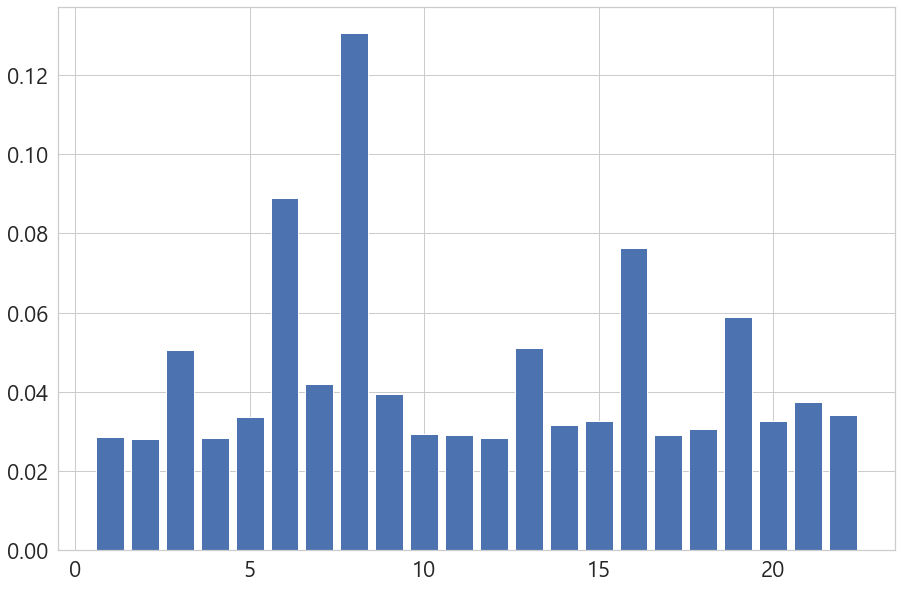

In [15]:
plt.bar(dictionary.keys(), dictionary.values())
plt.show()

3, 6, 8, 13, 16, 19 열이 화재 발생과 관련이 있음

In [59]:
# 검증
pred_xgb = model_xgb.predict(valid_X)

print(classification_report(valid['fire_yes'], pred_xgb))

evaluation(valid['fire_yes'], pred_xgb)

정확도(accuracy):  0.8315, 정밀도(precision):  0.5753, 재현율(recall):  0.330189, f1 score:  0.4196, auc값:  0.6375


### ROC 그리기

In [32]:
fpr, tpr, thresholds = roc_curve(valid['fire_yes'], model_xgb.predict_proba(valid_X)[:, 1])

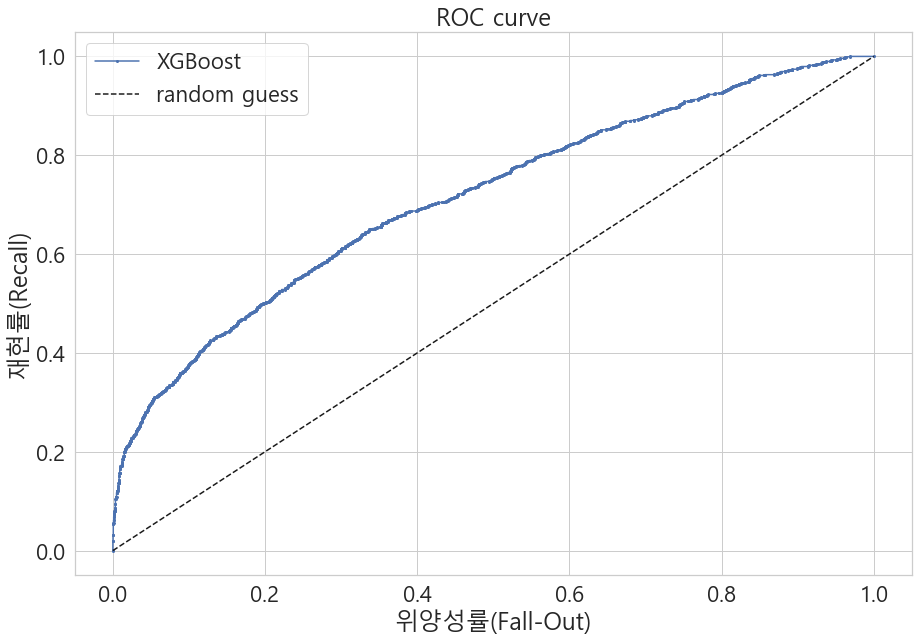

In [33]:
plt.plot(fpr, tpr, 'o-', ms=2, label="XGBoost")
plt.plot([0, 1], [0, 1], 'k--', label="random guess")
plt.legend()
plt.xlabel('위양성률(Fall-Out)')
plt.ylabel('재현률(Recall)')
plt.title('ROC curve')
plt.show()

In [34]:
auc(fpr1, tpr1) # ROC 커브 면적

0.6646195113880523

# XGBoost DMatrix

In [109]:
dtrain = xgb.DMatrix(train_X, label=train_y)

In [110]:
param = {'bst:max_depth':2, 'bst:eta':1, 'silent':1, 'objective':'binary:logistic' }

In [111]:
plst = param.items()

In [112]:
bst = xgb.train(plst,dtrain,)

In [113]:
dtest= xgb.DMatrix(valid_X)

In [114]:
ypred = bst.predict(dtest)

In [115]:
prediction_binomial_val = [1 if p>=0.4 else 0 for p in ypred]

In [116]:
print('f1', metrics.f1_score(prediction_binomial_val,valid['fire_yes']) )

f1 0.4618937644341801


In [117]:
evaluation(valid['fire_yes'], prediction_binomial_val)

정확도(accuracy):  0.7973, 정밀도(precision):  0.4525, 재현율(recall):  0.471698, f1 score:  0.4619, auc값:  0.6713


# 클러스터링한 데이터로 모델링

In [118]:
train_c = pd.read_csv("train_3rd_cluster.csv")
test_c = pd.read_csv("test_3rd_cluster.csv")
valid_c = pd.read_csv("valid_3rd_cluster.csv")

In [119]:
# 적어준 변수 목록을 사용해 데이터를 트레이닝에 맞는 포맷으로 변경합니다.
train_c_X = train_c[independents]
train_c_y = train_c[dependent]

test_c_X = test_c[independents]
valid_c_X = valid_c[independents]

In [120]:
dtrain_c = xgb.DMatrix(train_c_X, label=train_c_y)

In [121]:
bst_c = xgb.train(plst,dtrain_c,)

In [122]:
dtest_c= xgb.DMatrix(valid_c_X)

In [123]:
ypred_c = bst_c.predict(dtest_c)

In [124]:
prediction_binomial_val_c = [1 if p>=0.4 else 0 for p in ypred_c]

In [125]:
evaluation(valid_c['fire_yes'], prediction_binomial_val_c)

정확도(accuracy):  0.7799, 정밀도(precision):  0.4193, 재현율(recall):  0.502358, f1 score:  0.4571, auc값:  0.6725


# PCA한 걸로 모델링

In [ ]:
train_PCA = pd.read_csv("train_PCA.csv")
valid_PCA = pd.read_csv("valid_PCA.csv")

In [299]:
# 적어준 변수 목록을 사용해 데이터를 트레이닝에 맞는 포맷으로 변경합니다.
train_PCA_X = train_PCA[independents]
train_PCA_y = train_PCA[dependent]

valid_PCA_X = valid_PCA[independents]

In [300]:
dtrain_PCA = xgb.DMatrix(train_PCA_X, label=train_PCA_y)
bst_PCA = xgb.train(plst,dtrain_PCA,)
dtest_PCA= xgb.DMatrix(valid_PCA_X)
ypred_PCA = bst_PCA.predict(dtest_PCA)

In [301]:
prediction_binomial_val_PCA = [1 if p>=0.4 else 0 for p in ypred_PCA]

In [302]:
evaluation(valid_PCA['fire_yes'], prediction_binomial_val_PCA)

정확도(accuracy):  0.7773, 정밀도(precision):  0.4127, 재현율(recall):  0.490566, f1 score:  0.4483, auc값:  0.6664


# jmk 추가 클러스터링

In [244]:
train_c = pd.read_csv("train_3rd_cluster_jmk.csv")
test_c = pd.read_csv("test_3rd_cluster_jmk.csv")
valid_c = pd.read_csv("valid_3rd_cluster_jmk.csv")

In [245]:
# 적어준 변수 목록을 사용해 데이터를 트레이닝에 맞는 포맷으로 변경합니다.
train_c_X = train_c[independents]
train_c_y = train_c[dependent]

test_c_X = test_c[independents]
valid_c_X = valid_c[independents]

In [246]:
dtrain_c = xgb.DMatrix(train_c_X, label=train_c_y)

In [247]:
bst_c = xgb.train(plst,dtrain_c,)

In [248]:
dtest_c= xgb.DMatrix(valid_c_X)

In [249]:
ypred_c = bst_c.predict(dtest_c)

In [250]:
prediction_binomial_val_c = [1 if p>=0.4 else 0 for p in ypred_c]

In [251]:
evaluation(valid_c['fire_yes'], prediction_binomial_val_c)

정확도(accuracy):  0.7746, 정밀도(precision):  0.4124, 재현율(recall):  0.523585, f1 score:  0.4614, auc값:  0.6775


## 0과 2 군집 각각 나누어서 진행

In [252]:
train_c_0 = train_c[train_c['cluster']==0]
train_c_1 = train_c[train_c['cluster']==1]

In [253]:
valid_c_0 = valid_c[valid_c['cluster']==0]
valid_c_1 = valid_c[valid_c['cluster']==1]

In [254]:
# 적어준 변수 목록을 사용해 데이터를 트레이닝에 맞는 포맷으로 변경합니다.
train_c_0_X = train_c_0[independents]
train_c_1_X = train_c_1[independents]
train_c_0_y = train_c_0[dependent]
train_c_1_y = train_c_1[dependent]

valid_c_0_X = valid_c_0[independents]
valid_c_1_X = valid_c_1[independents]

In [255]:
dtrain_c_0 = xgb.DMatrix(train_c_0_X, label=train_c_0_y)
dtrain_c_1 = xgb.DMatrix(train_c_1_X, label=train_c_1_y)

In [256]:
bst_c_0 = xgb.train(plst,dtrain_c_0,)
bst_c_1 = xgb.train(plst,dtrain_c_1,)
dtest_c_0= xgb.DMatrix(valid_c_0_X)
dtest_c_1= xgb.DMatrix(valid_c_1_X)
ypred_c_0 = bst_c_0.predict(dtest_c_0)
ypred_c_1 = bst_c_1.predict(dtest_c_1)

In [257]:
prediction_binomial_val_c_0 = [1 if p>=0.11 else 0 for p in ypred_c_0]
prediction_binomial_val_c_1 = [1 if p>=0.3 else 0 for p in ypred_c_1]

In [258]:
evaluation(valid_c_0['fire_yes'], prediction_binomial_val_c_0)

정확도(accuracy):  0.4603, 정밀도(precision):  0.2544, 재현율(recall):  0.773669, f1 score:  0.3829, auc값:  0.5737


In [259]:
evaluation(valid_c_1['fire_yes'], prediction_binomial_val_c_1)

정확도(accuracy):  0.7167, 정밀도(precision):  0.2887, 재현율(recall):  0.541946, f1 score:  0.3767, auc값:  0.6457


In [260]:
concat_0 = pd.DataFrame(prediction_binomial_val_c_0, valid_c_0['id']).reset_index()

In [261]:
concat_1 = pd.DataFrame(prediction_binomial_val_c_1, valid_c_1['id']).reset_index()

In [262]:
concat_id = pd.concat([concat_0, concat_1])

In [263]:
valid_c_fire = valid_c.merge(concat_id, on ='id')

In [264]:
valid_c_fire = valid_c_fire.rename(columns={0: 'fire_pred'})

In [265]:
evaluation(valid_c_fire['fire_pred'], valid_c_fire['fire_yes'])

정확도(accuracy):  0.6006, 정밀도(precision):  0.6651, 재현율(recall):  0.266457, f1 score:  0.3805, auc값:  0.5760


# XGBoost 성능 비교
max_depth 의사결정나무 모형 깊이 초모수를 달리해서 XGBoost 예측모형의 성능을 비교해본다.

In [35]:
f1_score_list = []

max_depth_list = [10, 15]

In [36]:
for max_depth in max_depth_list:
    xgb_model = XGBClassifier(max_depth=max_depth)
    xgb_pred = xgb_model.fit(train_X, train_y).predict(valid_X)
    xgb_f1_score = f1_score(xgb_pred,valid['fr_yn'])
    f1_score_list.append(xgb_f1_score)

KeyboardInterrupt: 

In [ ]:
xgb_df = pd.DataFrame({'tree depth':max_depth_list, 'f1_score':f1_score_list})
xgb_df.head()

# XGBoost 시각화
XGBoost 모형을 시각화함으로써 개발한 예측모형의 성능에 대해 더 깊은 이해를 가질 수 있다. xgb.plot_importance() 메쏘드에 XGBoost 모형객체를 넣어 변수중요도를 파악할 수 있다.

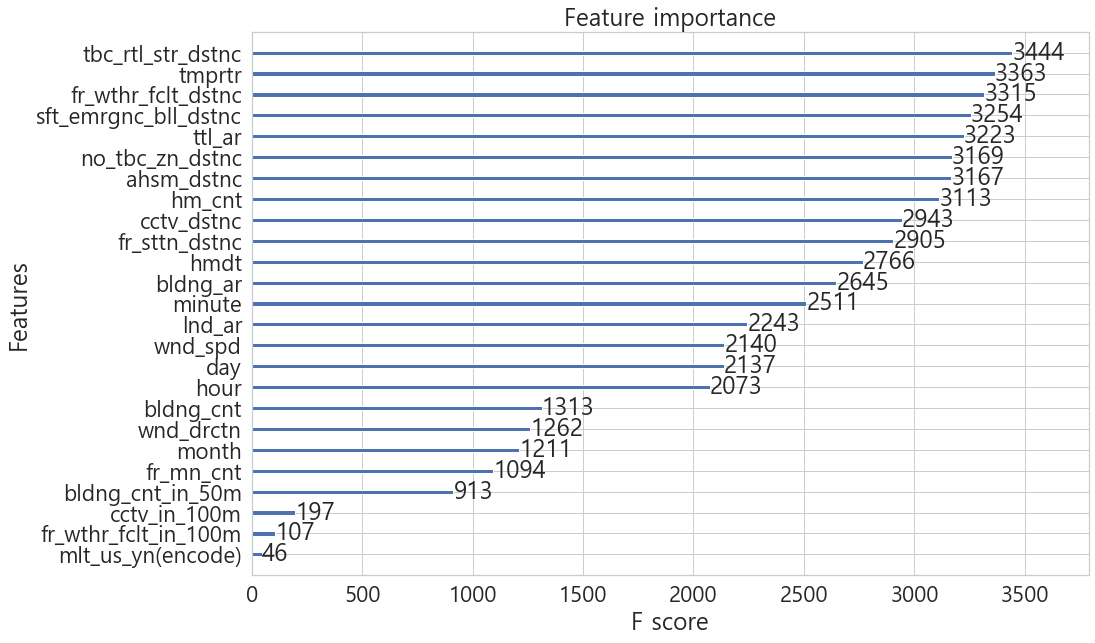

In [128]:
xgb.plot_importance(model_xgb)

## 클러스터링한 걸로 XGBoost 시각화

In [129]:
model_xgb_c = XGBClassifier(max_depth=10, n_estimators=300, learning_rate=0.05, verbose = True).fit(train_c_X, train_c_y)

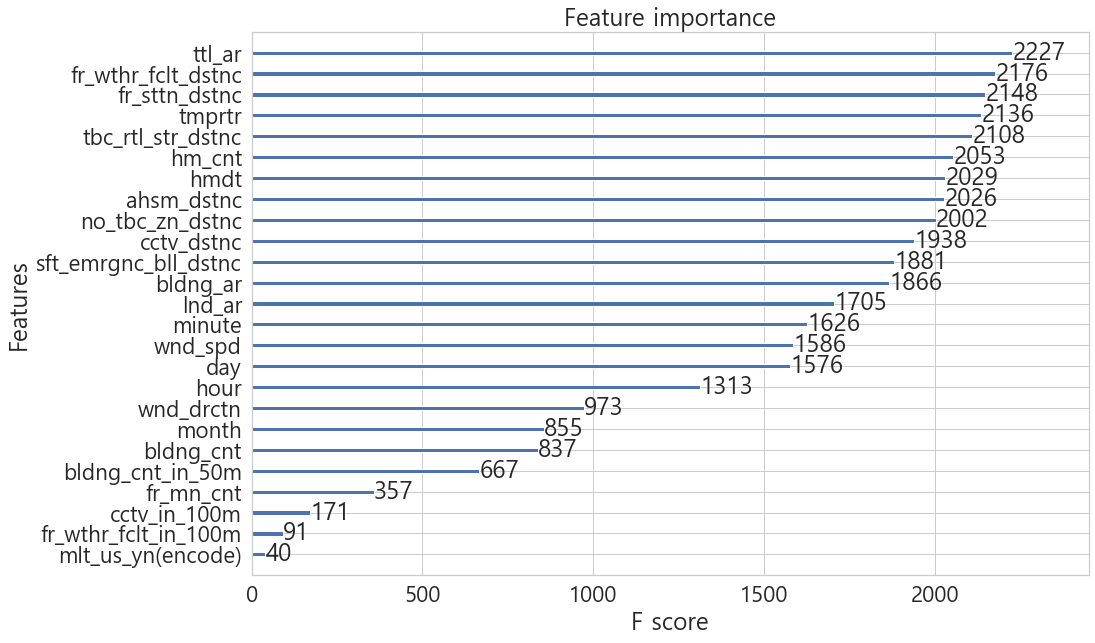

In [130]:
xgb.plot_importance(model_xgb_c)

# 2. 로지스틱 회귀분석 & ROC 커브

In [21]:
model_lr = LogisticRegression().fit(train_X, train_y)

In [24]:
pred_lr = model_lr.predict(valid_X)
# prediction2 = model2.predict(valid_X)

In [25]:
pred_lr

array([False, False, False, ..., False, False, False])

In [26]:
print('f1', metrics.f1_score(pred_lr,valid['fire_yes']) )

f1 0.1760113555713272


In [27]:
evaluation(valid['fire_yes'], pred_lr)

정확도(accuracy):  0.8317, 정밀도(precision):  0.9051, 재현율(recall):  0.097484, f1 score:  0.1760, auc값:  0.5476


In [28]:
fpr1, tpr1, thresholds1 = roc_curve(valid['fire_yes'], model_lr.predict_proba(valid_X)[:, 1])

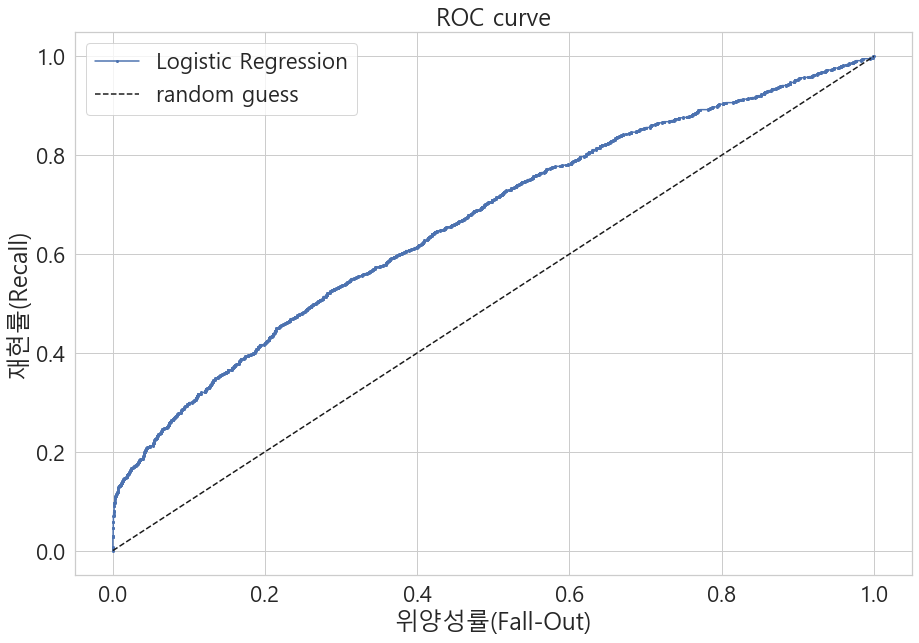

In [29]:
plt.plot(fpr1, tpr1, 'o-', ms=2, label="Logistic Regression")
plt.plot([0, 1], [0, 1], 'k--', label="random guess")
plt.legend()
plt.xlabel('위양성률(Fall-Out)')
plt.ylabel('재현률(Recall)')
plt.title('ROC curve')
plt.show()

In [30]:
auc(fpr1, tpr1) # ROC 커브 면적

0.6646195113880523

## 선형 회귀

In [100]:
model_reg = LinearRegression().fit(train_X, train_y)
# 대문자는 매트릭스, 소문자는 벡터

In [103]:
# x 계수
# x 계수의 의미를 해석하세요.
model_reg.coef_
# 피클래스가 한 계단 올라갈 때마다 죽음에 0.19배 가까워짐

array([[ 6.23359907e-04, -7.16793403e-05,  1.69645622e-03,
        -8.68243206e-05, -7.64814354e-09,  1.47777524e-07,
         1.33820246e-03,  3.05302288e-06,  3.87475868e-01,
         3.18098186e-04,  7.58087405e-03,  5.28528141e-06,
        -1.72506832e-03,  1.35804255e-07, -3.02263910e-06,
        -2.07209268e-05,  2.82131291e-06,  7.36810710e-03,
         1.29792978e-04, -4.77662709e-07,  4.89593907e-07,
        -4.84821945e-06,  3.64320546e-04]])

In [104]:
# 절편
model_reg.intercept_

array([0.21869984])

In [ ]:
reg.score(train_X, train_y, sample_weight=None)

In [105]:
pred_reg = model_reg.predict(valid_X)

In [122]:
pred_binomial = [1 if p>=0.2 else 0 for p in pred_reg]

In [123]:
print('f1', metrics.f1_score(pred_binomial,valid['fr_yn']) )

f1 0.361843858246736


# RANDOM FOREST

In [124]:
model_forest = RandomForestClassifier(random_state=42, n_estimators=10).fit(train_X, train_y)

In [125]:
model_forest.feature_importances_

array([0.02514199, 0.03466388, 0.03768561, 0.04007   , 0.04727033,
       0.09146986, 0.02551794, 0.09234866, 0.00125666, 0.04739237,
       0.0387478 , 0.02592874, 0.05491994, 0.04881427, 0.05001474,
       0.06465765, 0.04709763, 0.00847794, 0.03034936, 0.0508745 ,
       0.05512908, 0.06112974, 0.02104129])

In [126]:
pred_forest = model_forest.predict(valid_X)

In [127]:
pred_forest

array([False, False, False, ..., False, False, False])

In [128]:
print('f1', metrics.f1_score(pred_forest,valid['fr_yn']) )

f1 0.33171258779038354


In [129]:
evaluation(valid['fr_yn'], pred_forest)

정확도(accuracy):  0.8207, 정밀도(precision):  0.5302, 재현율(recall):  0.241352, f1 score:  0.3317, auc값:  0.5965


# 클러스터링한 걸로 모델링

In [230]:
model_forest_c = RandomForestClassifier(random_state=42, n_estimators=10).fit(train_c_X, train_c_y)

In [231]:
pred_forest_c = model_forest_c.predict(valid_c_X)

In [233]:
evaluation(valid_c['fire_yes'], pred_forest_c)

정확도(accuracy):  0.8204, 정밀도(precision):  0.5242, 재현율(recall):  0.280660, f1 score:  0.3656, auc값:  0.6115


# VALIDATION 한 번에 돌리기

In [268]:
def train_and_val(model, num):
    a = model.fit(train_X, train_y)
    prediction_val = a.predict(valid_X)
    prediction_binomial_val = [1 if p>=num else 0 for p in prediction_val]
    print('f1:', f1_score(prediction_binomial_val,valid['fr_yn']) )
    return prediction_val

In [142]:
train_and_val(LogisticRegression(), 0.5)

f1: 0.1760113555713272


array([False, False, False, ..., False, False, False])

In [163]:
train_and_val(RandomForestClassifier(n_estimators=700, oob_score=True, max_depth=12, min_samples_leaf=16, min_samples_split=8, n_jobs=-1), 0.5)

f1: 0.3548574752763234


array([False, False, False, ..., False, False,  True])

In [150]:
train_and_val(RandomForestClassifier(random_state=10, n_estimators=100, max_depth = 15), 0.5)

f1: 0.3759820426487093


array([False, False, False, ..., False, False,  True])

In [162]:
params = {
    'n_estimators': [100],
    'max_depth': [6, 8, 10, 12],
    'min_samples_leaf': [8, 12, 16],
    'min_samples_split': [8, 16, 24]
}

rf_clf = RandomForestClassifier(random_state=0, n_jobs=-1)
grid_cv = GridSearchCV(rf_clf, param_grid=params, cv=2, n_jobs=-1)
grid_cv.fit(train_X, train_y)

print("최적 하이퍼 파라미터: ", grid_cv.best_params_)
print("최고 예측 정확도: ", grid_cv.best_score_)

최적 하이퍼 파라미터:  {'max_depth': 12, 'min_samples_leaf': 16, 'min_samples_split': 8, 'n_estimators': 100}
최고 예측 정확도:  0.8805899545539018


In [161]:
params = {
    'n_estimators': [100, 300, 500]
}
rf_clf_1 = RandomForestClassifier(max_depth=12, min_samples_leaf=16, min_samples_split=8, n_jobs=-1)
grid_cv = GridSearchCV(rf_clf_1, param_grid=params, cv = 3, n_jobs=-1)
grid_cv.fit(train_X, train_y)
print("최적 파라미터: ", grid_cv.best_params_)
print("최고 예측 정확도: ", grid_cv.best_score_)
best_model = grid_cv.best_estimator_
pred = best_model.predict(valid_X)
f1 = f1_score(valid['fire_yes'], pred)
print("f1 score: {0: .4f}".format(f1))

최적 파라미터:  {'n_estimators': 500}
최고 예측 정확도:  0.8771941680323022
f1 score:  0.3716


In [145]:
train_and_val(KNeighborsClassifier(n_neighbors = 4), 0.1)

f1: 0.2458547741566609


array([False, False, False, ..., False, False, False])

In [148]:
train_and_val(GaussianNB(), 0.5)

f1: 0.20083102493074792


array([False, False, False, ..., False, False, False])

In [ ]:
# train_and_val(SVC())

# 클러스터링한 애들로 한 번에 돌리기

In [267]:
def train_and_val_c(model, num):
    a = model.fit(train_c_X, train_c_y)
    prediction_val = a.predict(valid_c_X)
    prediction_binomial_val = [1 if p>=num else 0 for p in prediction_val]
    print('f1:', f1_score(prediction_binomial_val,valid['fr_yn']) )
    return prediction_val

In [269]:
train_and_val_c(LogisticRegression(), 0.5)

f1: 0.1897399859451862


array([0., 0., 0., ..., 0., 0., 0.])

In [270]:
train_and_val_c(RandomForestClassifier(n_estimators=700, oob_score=True, max_depth=12, min_samples_leaf=16, min_samples_split=8, n_jobs=-1), 0.5)

f1: 0.3624856156501726


array([0., 0., 0., ..., 0., 0., 1.])

In [271]:
train_and_val_c(RandomForestClassifier(random_state=10, n_estimators=100, max_depth = 15), 0.5)

f1: 0.37750135208220664


array([0., 0., 0., ..., 0., 0., 1.])

In [272]:
train_and_val_c(KNeighborsClassifier(n_neighbors = 4), 0.1)

f1: 0.21271393643031786


array([0., 0., 0., ..., 0., 0., 0.])

In [273]:
train_and_val_c(GaussianNB(), 0.5)

f1: 0.20097020097020096


array([0., 0., 0., ..., 0., 0., 0.])